In [ ]:
import my_utils as mu
import torch
from torch import nn
from torch.utils import data
from IPython import display
import matplotlib.pyplot as plt

In [ ]:
#Load Fashion Mnist data from NNDL material my_utils.py
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


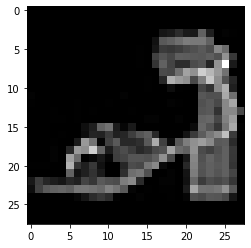

In [ ]:
img, labels = next(iter(train_iter))
plt.imshow(img[0].squeeze(), cmap="gray")
plt.show()

In [ ]:
#The Stem
#image height x width, dividies it np patches so image is split into grids
#each patch has dimension kxk so all equal grids
#vectorize each patch, make it a vector. then transform to feature vector 
#the transformed layorcan be a linear layer or a single hidden layer mlp
#all features stored n matrix Xij of dimension d.i
#for each patch you compute a different vector
# outcome of features is matrix x of dimension np(number of patches) * d

I have used unfold to extract proper patches that do not overlap. This method was from user ptrblck from Pytorch
https://discuss.pytorch.org/t/how-to-extract-smaller-image-patches-3d/16837/3
The line this citation refers to is the following:
"patches = images.unfold(2, self.height, self.width).unfold(3, self.height, self.width)"

In [ ]:
class Patches(torch.nn.Module):
    def __init__(self, height, width):
        super(Patches, self).__init__()
        self.height = height
        self.width = width
        self.Linear1 = nn.Linear(16, 16)
        
    def __call__(self, images):
        patches = images.unfold(2, self.height, self.width).unfold(3, self.height, self.width)
        patch = patches.reshape(-1, 49, 16) # 49 patches of 16 pixels
        patch = self.Linear1(patch) #transform to feature vector, linear layer
        return patch #returns matrix

In [ ]:
#Testing the Patches class below
#Image is 28x28, so we can do 1, 2, 4, 7, 14, 28
Patch = Patches(4,4)
imagePatch = Patch(img)
print(imagePatch.shape)
patches = imagePatch.view(imagePatch.shape[0], -1)
# fig, ax = plt.subplots(7, 7)
# index=0
# for i in range(7):
#   for j in range(7):
#     ax[i][j].imshow(torch.transpose(patches[0][index], 0,1).squeeze(), cmap="gray")
#     ax[i][j].axis('off')
#     index+=1

torch.Size([256, 49, 16])


In [ ]:
#Backbone
#need to define w1,w2,w3,w4
#can also add bias if u want
# each block will consists of 4 hidden layers
# consists of up to n blocks, each block is the same
# inside each block there is two mlps
# mlp 1 x -> xT -> o1
# o1 <- o1T
#o1 -> mlp2 -> o2
# no cnns, but u can use tricks from weeks 5-8
#Classifier
#takes output of the block or last block
#output will be a matrix of np rows with d0 features
#take average of matrix rows and get a single vector
# can be softmax regression classifier
#also can use tricks from weeks 5-8

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
      super(MLP, self).__init__()
      self.patches = Patches(4,4)
      self.relu = nn.ReLU()
      #mlp1
      self.Linear1 = nn.Linear(49, 512, False)
      self.Linear2 = nn.Linear(512, 49, False)
      #mlp2
      self.Linear3 = nn.Linear(16,256, False)
      self.Linear4 = nn.Linear(256,10, False)
    def forward(self, x):
      patches = self.patches(x) 
      #patches returns all features
      # i transpose x 1,2 as i do not want to
      # transpose the batch size, and then
      # i work out the linear layer
      x = torch.transpose(patches, 1,2)
      x = self.Linear1(x) 
      #relu and work out the 2nd linear layer
      x = self.relu(x) 
      x = self.Linear2(x)
      # we then transpose the outcome of o1
      x = torch.transpose(x, 1,2)
      # x is now equal to o1 which is the first mlp
      # then i pass this into the second mlp, o2
      x = self.Linear3(x)
      x = self.relu(x)
      x = self.Linear4(x)
      # for the classifier, we return the mean features
      # and we call softmax regression from my_utils
      # when the function mu.train_ch3 is called
      x = torch.mean(x, dim=1)
      return x

In [ ]:
#Using kaiming_uniform, I do not use bias so i do no initialise them.
#I took inspiration from week 5 NNDl material for the kaiming uniform initialization.
def init_weights(m):
  if isinstance(m, nn.Linear): 
    torch.nn.init.kaiming_uniform_(m.weight) 

mlp = MLP() 
mlp.apply(init_weights);
print(mlp)

MLP(
  (patches): Patches(
    (Linear1): Linear(in_features=16, out_features=16, bias=True)
  )
  (relu): ReLU()
  (Linear1): Linear(in_features=49, out_features=512, bias=False)
  (Linear2): Linear(in_features=512, out_features=49, bias=False)
  (Linear3): Linear(in_features=16, out_features=256, bias=False)
  (Linear4): Linear(in_features=256, out_features=10, bias=False)
)


In [ ]:
#Using lab 5 materials from NNDL for CE loss and SGD optimizer
loss = nn.CrossEntropyLoss()
lr, wd = 0.1, 0 #model works best without weight decay
optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, weight_decay=wd)

In [ ]:
#you can use different hyperparameters to improve accuracy
#i.e batch size, learning grade, optimizer, hidden dimensions 

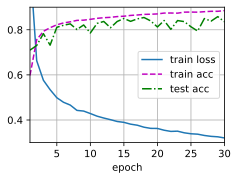

In [ ]:
num_epochs = 30
mu.train_ch3(mlp, train_iter, test_iter, loss, num_epochs, optimizer)